In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df_train = pd.read_csv("train.txt", delimiter=';', header=None, names=['sentence','label'])

In [4]:
df_train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


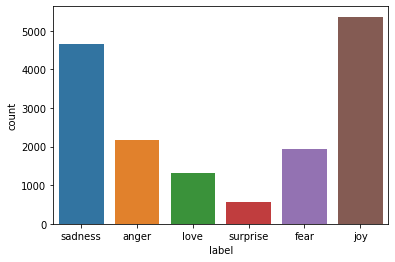

In [5]:
sns.countplot(df_train['label'])


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from nltk.corpus import stopwords 
import string

In [8]:
#important!!
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    word_seq=[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return word_seq

In [9]:
text=df_train['sentence'].apply(text_process)
text.head()

0                            [didnt, feel, humiliated]
1    [go, feeling, hopeless, damned, hopeful, aroun...
2    [im, grabbing, minute, post, feel, greedy, wrong]
3    [ever, feeling, nostalgic, fireplace, know, st...
4                                   [feeling, grouchy]
Name: sentence, dtype: object

In [10]:
df_train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [12]:
max_len=100
max_words=20000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)
sequences=tokenizer.texts_to_sequences(text)
#sequences

In [13]:
data=pad_sequences(sequences,maxlen=max_len)
data

array([[   0,    0,    0, ...,   49,    1,  562],
       [   0,    0,    0, ...,   55, 1349, 1125],
       [   0,    0,    0, ...,    1,  381,  326],
       ...,
       [   0,    0,    0, ...,  218,   32, 1201],
       [   0,    0,    0, ..., 1106,    4,  230],
       [   0,    0,    0, ...,    1,  175, 3444]], dtype=int32)

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [15]:
encode=LabelEncoder()

In [16]:
y=encode.fit_transform(df_train['label'])
y_data=np_utils.to_categorical(y)
y_data.shape

(16000, 6)

In [17]:
y_data

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [18]:
len(data)
len(y_data)

#data is train x and y_data is train y

16000

In [19]:
x_train = data[:13000]
y_train = y_data[:13000]
x_val = data[13000:]
y_val = y_data[13000:]

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dropout,Dense,Bidirectional,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
y_data.shape[1]

6

In [22]:
#model building
model=Sequential()
model.add(Embedding(max_words,64,input_length=max_len))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dense(y_data.shape[1],activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 1,418,630
Trainable params: 1,418,630
Non-trainable params: 0
_________________________________________________________________


In [24]:
es=EarlyStopping(monitor='val_loss')

In [27]:
predictions=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=3,callbacks=[es])

Epoch 1/3
407/407 [==============================] - 65s 160ms/step - loss: 0.2739 - accuracy: 0.9102 - val_loss: 0.3272 - val_accuracy: 0.8927


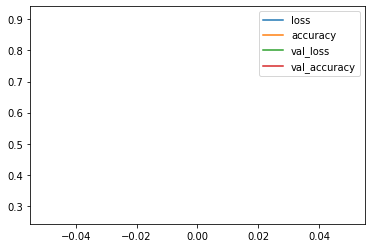

In [29]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [30]:
#testing data
df_test= pd.read_csv("test.txt", delimiter=';', header=None, names=['sentence','label'])

In [31]:
df_test.head()

,sentence,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [32]:
testing_text=df_test['sentence'].apply(text_process)

In [33]:
len(testing_text)

2000

In [34]:
#encoding test side
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(testing_text)
test_sequences=tokenizer.texts_to_sequences(testing_text)
test_data=pad_sequences(test_sequences,maxlen=max_len)
testing_labels=encode.fit_transform(df_test['label'])
testing_labels=np_utils.to_categorical(testing_labels)
testing_labels.shape

(2000, 6)

In [ ]:
test_predictions=model.fit(test_data,testing_labels,epochs=30,callbacks=[es])

Epoch 1/30
63/63 [==============================] - 9s 139ms/step - loss: 1.9361 - accuracy: 0.3190
Epoch 2/30
63/63 [==============================] - 9s 138ms/step - loss: 1.5407 - accuracy: 0.3855
Epoch 3/30
63/63 [==============================] - 9s 138ms/step - loss: 1.4923 - accuracy: 0.4070
Epoch 4/30
63/63 [==============================] - 9s 138ms/step - loss: 1.3653 - accuracy: 0.4790
Epoch 5/30
63/63 [==============================] - 9s 141ms/step - loss: 1.1111 - accuracy: 0.5850
Epoch 6/30
63/63 [==============================] - 9s 138ms/step - loss: 0.7842 - accuracy: 0.7230
Epoch 7/30
63/63 [==============================] - 9s 140ms/step - loss: 0.4682 - accuracy: 0.8510
Epoch 8/30
63/63 [==============================] - 9s 139ms/step - loss: 0.2610 - accuracy: 0.9210
Epoch 9/30
63/63 [==============================] - 9s 141ms/step - loss: 0.1596 - accuracy: 0.9560
Epoch 10/30
63/63 [==============================] - 9s 141ms/step - loss: 0.0892 - accuracy: 0.9745

In [ ]:
encode.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)